In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from sklearn.metrics import recall_score, precision_score,accuracy_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score,roc_curve

In [2]:
f=r'Desktop/default_credit_b.csv'
#f=r'C:\ChromeCoreDownloads\default_credit_b.csv'
data = pd.read_csv(f)
print('成功读取数据共{} '.format(data.shape))
data.head()

成功读取数据共(30000, 15) 


,id,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,25115,1,-1.486041,-0.695628,-0.682385,-0.674713,-0.675078,-0.672187,-0.668576,-0.281506,-0.256946,-0.296744,-0.307999,-0.314071,-0.293326
1,2346,0,-0.616452,-0.418693,-0.411269,-0.385059,-0.429740,-0.659456,-0.632490,-0.255907,0.624502,-0.238869,-0.294083,-0.235265,-0.287251
2,2613,0,-1.486041,-0.695642,-0.690983,-0.483273,-0.531385,-0.481978,-0.549086,-0.341942,0.328892,0.221014,0.394674,0.089842,-0.244499
3,15473,0,0.253137,-0.643723,1.413661,0.138401,0.530734,0.641564,0.589780,8.732378,0.203808,1.123115,-0.114393,-0.116991,-0.011447
4,12900,0,-1.486041,-0.580438,-0.557140,-0.190706,-0.672777,-0.663355,-0.653026,0.233558,1.209473,-0.296801,-0.308063,-0.314136,-0.293382


In [3]:
##cluster 测试集训练集
data_x = data[data.columns[2:]]
data_y = data[data.columns[1]]

In [186]:
## gmm cluter
clf=GaussianMixture(n_components=3,covariance_type='full', tol = 1e-5, random_state=0)
clf.fit(data_x)
result=clf.predict(data_x)

In [192]:
clf.weights_

array([0.19304933, 0.4696453 , 0.33730537])

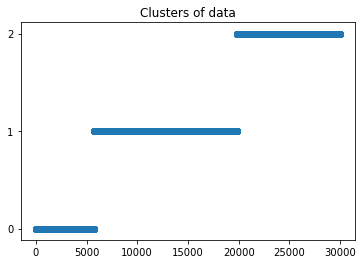

In [188]:
## 簇类的数量
def plot_clusters(x, K):
    x.sort()
    plt.scatter(range(len(x)),x)
    plt.yticks(range(K))
    plt.title('Clusters of data')
plot_clusters(result,3)

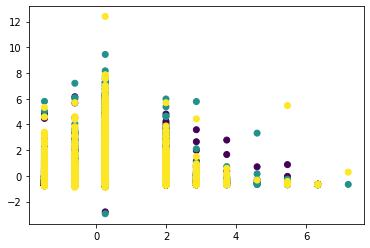

In [12]:
plt.scatter(data.iloc[:,2],data.iloc[:,3],c=result)

In [149]:
##分类的测试集，训练集
xtrain,xtest,ytrain,ytest = train_test_split(data_x, data_y, test_size=0.25, random_state = 42)

In [176]:
##MLP 分类
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)

model = MLPClassifier(hidden_layer_sizes=[10,10],alpha=0.1,random_state=0,
                     solver='lbfgs',verbose=0)
model.fit(X_train_scaled,ytrain)
ypred = model.predict(X_test_scaled)
yscore = model.predict_proba(X_test_scaled)[:,1]

C:\Users\xiaokeai\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [204]:
##分析模型
from sklearn.metrics import classification_report

response = classification_report(ytest, ypred, target_names=['0', '1'])

In [290]:
responsedict = {1:['0.80','0.63','0.76'], 2 :['0.97','0.16','0,79'], 3:['0.88','0.25','0.73'], 4:['5795','1705','7500'] }
response = pd.DataFrame(responsedict)
response = response.rename({2:'avg/total'})
response.columns=["precision", "recall","f1_score","support"]
response

,precision,recall,f1_score,support
0,0.80,0.97,0.88,5795
1,0.63,0.16,0.25,1705
avg/total,0.76,"0,79",0.73,7500


C:\Users\xiaokeai\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


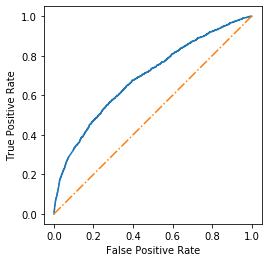

In [291]:
##roc曲线
fpr_lr, tpr_lr,_ = roc_curve(ytest,yscore)
roc = plt.plot(fpr_lr,tpr_lr)
plt.axes().set_aspect('equal')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],'-.')
plt.show()

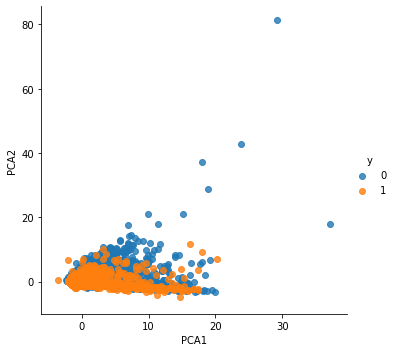

In [9]:
##PCA降维，以y为标准
from sklearn.decomposition import PCA
model=PCA(n_components=2)
model.fit(data_x)
X_2d = model.transform(data_x)
data['PCA1'] = X_2d[:,0]
data['PCA2'] = X_2d[:,1]
sns.lmplot('PCA1','PCA2',data=data,hue='y',fit_reg=False)

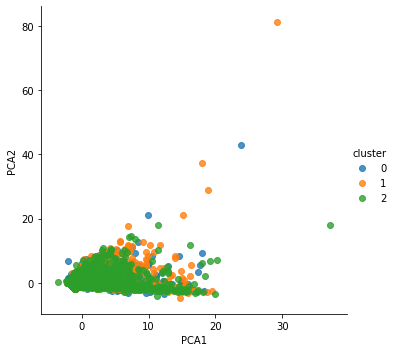

In [10]:
##PCA降维，以cluster结果为标准
from sklearn.decomposition import PCA
model=PCA(n_components=2)
model.fit(data_x)
X_2d = model.transform(data_x)
data['PCA1'] = X_2d[:,0]
data['PCA2'] = X_2d[:,1]
data['cluster'] = result
sns.lmplot('PCA1','PCA2',data=data,hue='cluster',fit_reg=False)

In [65]:
# 主函数
def update_prob(prob, input_data,lamb, para, k):
    '''
    更新GMM的 状态转移矩阵prob
    :param prob: 状态转移矩阵prob，NxK
    :param lamb: 分布向量  ##每个模型比例的先验概率
    :param para: 关于数据分布的参数
    :param k: clusters 的数量
    :return: 返回状态转移矩阵prob
    '''
    for j in range(0, k):
        tmp = multivariate_normal.pdf(input_data, para[0][j], para[1][j])+1e-30
        prob.iloc[:, j] = (lamb[j])*(tmp)
        #converg_flag = math.log(prob.sum(axis=1).sum())
    return prob.apply(lambda x: x / prob.sum(axis=1))#,converg_flag


def update_para(prob, input_data, lamb, para, n, k):
    para[0] = [prob.iloc[:, j].values.dot(input_data.values) / (n * lamb[j]) for j in range(k)]
    # poisson distr OR gaussian distr
    if len(para) == 2:
        l = []
        for j in range(k):
            tmp = input_data.values - para[0][j]
            tmp = (tmp.T * prob.iloc[:, j].values).dot(tmp)/ (n * lamb[j])
            # tmp = np.diag(prob.iloc[:,j].values.dot(tmp**2)/(n*lamb[j]))
            #tmp = np.linalg.inv(tmp)
            l.append(tmp)
            para[1] = np.array(l)
    return [np.nan_to_num(arr) for arr in para]


def meet_requrement(lamb, threshold=1e-3):
    if any([p < threshold for p in lamb]): return True
    return False


def EM(k, input_data, max_step, threshold, para):
    '''
    多维特征的EM聚类
    :param k: 聚类数量
    :param input_data: 数据
    :param max_step: 最大迭代次数
    :param threshold: 误差阈值
    :return: 股票代码及其所属类
    '''
    n = input_data.shape[0]
    d = input_data.shape[1]
    losses = []

    ##initial probability distribution vector
    lamb = np.repeat(1 / k, k)
    ##initial probability matrix
    prob = pd.DataFrame(np.zeros((n, k)))
    print('Start training! prob:', prob.shape)
    
    
    ##start iteration
    for step in range(0, max_step):
        losses.append(lamb[2])
        # show process
        if (step) % 2 == 0:
            print()
            print('# Step:{} lamb:{}'.format(step, lamb))

        ##E-step: find the probability of x_i belonging to j group
        #

        prob = update_prob(prob, input_data, lamb, para, k)

        ##find the expectation of lambda
        lamb = prob.mean(axis=0).values
    
        ##M-step: maximize the pivotal function == MLE of normal distribution
        para = update_para(prob, input_data, lamb, para, n, k)
        
        ##stop condition
        if meet_requrement(lamb, threshold): break
    return prob.apply(lambda x: np.argmax(x), axis=1), losses, para

#scale data
def scale_data(input_data):
    # 对每一维特征分别进行缩放
    Y = input_data
    for i in range(Y.shape[1]):
        max_ = Y.iloc[:, i].max()
        min_ = Y.iloc[:, i].min()
        Y.iloc[:, i] = (Y.iloc[:, i] - min_) / (max_ - min_)
    input_data = Y
    return input_data

#根据sklearn定义初始paras（means，variance）
def distribute_covar_matrix_to_match_covariance_type(tied_cv, covariance_type, n_components):
    if covariance_type == 'spherical':
        cv = np.tile(tied_cv.mean() * np.ones(tied_cv.shape[1]),
                     (n_components, 1))
    elif covariance_type == 'tied':
        cv = tied_cv
    elif covariance_type == 'diag':
        cv = np.tile(np.diag(tied_cv), (n_components, 1))
    elif covariance_type == 'full':
        cv = np.tile(tied_cv, (n_components, 1, 1))
    else:
        raise ValueError("covariance_type must be one of " +
                         "'spherical', 'tied', 'diag', 'full'")
    return cv

def init_para(self, n_components, covariance_type, init_params='kmeans',random_state=None,min_covar=1e-3):
    self.init_params=init_params
    self.min_covar = min_covar
    self.means_ = KMeans(n_clusters=n_components,
                    random_state=random_state).fit(self).cluster_centers_
    
    cv = np.cov(self.T) + self.min_covar * np.eye(self.shape[1])
    if not cv.shape:
        cv.shape = (1, 1)
    self.covars_ = distribute_covar_matrix_to_match_covariance_type(cv,covariance_type, n_components)
    para =[]
    para.append(self.means_)
    para.append(self.covars_)
    return para

In [70]:
##参数定义
n_components = 3
input_data = data_x.iloc[:200,:]
covariance_type = 'full'
input_data = data_x
d = input_data.shape[1]
n = input_data.shape[0]
threshold = 1e-3
max_step=100
k=3

In [71]:
#初始para
scale_data(input_data)
para = init_para(data_x, n_components, covariance_type, init_params='kmeans',random_state=None,min_covar=1e-3)
para

C:\Users\Joy\Anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


[array([[0.0536627 , 0.15846731, 0.07655662, 0.09125409, 0.1663909 ,
         0.08519205, 0.26512267, 0.00547894, 0.00294744, 0.00474654,
         0.00617144, 0.01304926, 0.00995642],
        [0.23839939, 0.18362513, 0.10479911, 0.10799848, 0.19493448,
         0.11586567, 0.28706826, 0.00492183, 0.00270138, 0.0047272 ,
         0.00650507, 0.00672814, 0.00690123],
        [0.21531659, 0.3294921 , 0.25883895, 0.1938469 , 0.33158977,
         0.24862552, 0.38531649, 0.01661133, 0.00892975, 0.01412237,
         0.01834292, 0.02646339, 0.02309325]]),
 array([[[ 1.42247182e-02,  1.55389473e-03,  1.76268201e-03,
           1.05605135e-03,  1.85623659e-03,  2.01666071e-03,
           1.50045124e-03, -3.26261956e-06, -8.21720468e-06,
           1.31824746e-05,  5.51729957e-05, -1.91272578e-04,
          -9.78342351e-05],
         [ 1.55389473e-03,  5.24572567e-03,  4.18771362e-03,
           2.21373137e-03,  3.39695269e-03,  3.25944317e-03,
           2.39357794e-03,  1.73308955e-04,  8.85637

In [72]:
a,losses,paras = EM(k, input_data,100, threshold, para)

Start training! prob: (30000, 3)

# Step:0 lamb:[0.33333333 0.33333333 0.33333333]

# Step:2 lamb:[0.31341706 0.56326864 0.12331429]

# Step:4 lamb:[0.11740464 0.76622143 0.11637393]

# Step:6 lamb:[0.1603429  0.73258841 0.10706869]

# Step:8 lamb:[0.18738969 0.70849744 0.10411287]

# Step:10 lamb:[0.20902325 0.69057437 0.10040239]

# Step:12 lamb:[0.23411015 0.67035677 0.09553308]

# Step:14 lamb:[0.26437041 0.64358854 0.09204105]

# Step:16 lamb:[0.28526552 0.62153083 0.09320366]

# Step:18 lamb:[0.29663725 0.60638107 0.09698168]

# Step:20 lamb:[0.30352324 0.59643217 0.10004458]

# Step:22 lamb:[0.30723689 0.59062057 0.10214254]

# Step:24 lamb:[0.30998168 0.58644947 0.10356885]

# Step:26 lamb:[0.31190958 0.58354689 0.10454354]

# Step:28 lamb:[0.3131554  0.58163872 0.10520588]

# Step:30 lamb:[0.3138798 0.5804787 0.1056415]

# Step:32 lamb:[0.3142434  0.57984431 0.1059123 ]

# Step:34 lamb:[0.31438822 0.57954338 0.1060684 ]

# Step:36 lamb:[0.31442197 0.57942757 0.10615046]

# Ste

C:\Users\Joy\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


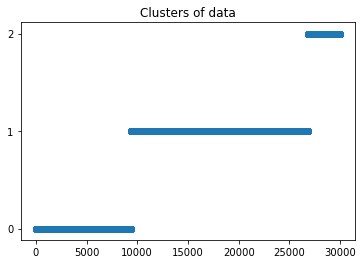

In [73]:
def plot_clusters(x, K):
    x = np.array(x)
    x.sort()
    plt.scatter(range(len(x)),x)
    plt.yticks(range(K))
    plt.title('Clusters of data')
plot_clusters(a,3)

In [55]:
##源码中定义的para
def init_para(k,d,type_='gaussian'):
    para = [init_mu_minmax(k,d)]
    if type_ == 'gaussian':
        para.append(init_sigma(k,d))
    return para
para=init_para(k,d,type_='gaussian')

In [56]:
para

[array([[ 2.09156847, -0.12914353, 12.09408996,  1.2526149 ,  8.20801469,
         12.81428141, -2.25643028, 35.29761641, 31.03646369, 15.08979891,
         17.10514392,  3.07534498, 27.43148653],
        [ 6.57798941, -0.88988896, 12.5447876 , -1.89063825,  1.61815593,
         14.31754799, -2.97739102, 26.95769437, 31.02486766,  9.16063365,
         13.80783724, 20.70539902,  1.35153265],
        [-1.42940461, -1.50595371,  7.90975852,  9.01103474,  2.09351988,
         11.67849563, -6.02328064,  9.86888135, 42.415255  , 38.79391694,
         23.43453569, 21.74158514,  7.99499842]]),
 array([[[   9.58620381,    0.        ,    0.        ,    0.        ,
             0.        ,    0.        ,    0.        ,    0.        ,
             0.        ,    0.        ,    0.        ,    0.        ,
             0.        ],
         [   0.        ,   88.64325443,    0.        ,    0.        ,
             0.        ,    0.        ,    0.        ,    0.        ,
             0.        ,    0. 

In [232]:
###github gmm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

DEBUG = True

######################################################
# 调试输出函数
# 由全局变量 DEBUG 控制输出
######################################################
def debug(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)


######################################################
# 第 k 个模型的高斯分布密度函数
# 每 i 行表示第 i 个样本在各模型中的出现概率
# 返回一维列表
######################################################
def phi(Y, mu_k, cov_k):
    norm = multivariate_normal(mean=mu_k, cov=cov_k)
    return norm.pdf(Y)


######################################################
# E 步：计算每个模型对样本的响应度
# Y 为样本矩阵，每个样本一行，只有一个特征时为列向量
# mu 为均值多维数组，每行表示一个样本各个特征的均值
# cov 为协方差矩阵的数组，alpha 为模型响应度数组
######################################################
def getExpectation(Y, mu, cov, alpha):
    # 样本数
    N = Y.shape[0]
    # 模型数
    K = alpha.shape[0]

    # 为避免使用单个高斯模型或样本，导致返回结果的类型不一致
    # 因此要求样本数和模型个数必须大于1
    assert N > 1, "There must be more than one sample!"
    assert K > 1, "There must be more than one gaussian model!"

    # 响应度矩阵，行对应样本，列对应响应度
    gamma = np.mat(np.zeros((N, K)))

    # 计算各模型中所有样本出现的概率，行对应样本，列对应模型
    prob = np.zeros((N, K))
    for k in range(K):
        prob[:, k] = phi(Y, mu[k], cov[k])
    prob = np.mat(prob)

    # 计算每个模型对每个样本的响应度
    for k in range(K):
        gamma[:, k] = alpha[k] * prob[:, k]
    for i in range(N):
        gamma[i, :] /= np.sum(gamma[i, :])
    return gamma


######################################################
# M 步：迭代模型参数
# Y 为样本矩阵，gamma 为响应度矩阵
######################################################
def maximize(Y, gamma):
    # 样本数和特征数
    N, D = Y.shape
    # 模型数
    K = gamma.shape[1]

    #初始化参数值
    mu = np.zeros((K, D))
    cov = []
    alpha = np.zeros(K)

    # 更新每个模型的参数
    for k in range(K):
        # 第 k 个模型对所有样本的响应度之和
        Nk = np.sum(gamma[:, k])
        # 更新 mu
        # 对每个特征求均值
        mu[k, :] = np.sum(np.multiply(Y, gamma[:, k]), axis=0) / Nk
        # 更新 cov
        cov_k = (Y - mu[k]).T * np.multiply((Y - mu[k]), gamma[:, k]) / Nk
        cov.append(cov_k)
        # 更新 alpha
        alpha[k] = Nk / N
    cov = np.array(cov)
    return mu, cov, alpha


######################################################
# 数据预处理
# 将所有数据都缩放到 0 和 1 之间
######################################################
def scale_data(Y):
    # 对每一维特征分别进行缩放
    for i in range(Y.shape[1]):
        max_ = Y.iloc[:, i].max()
        min_ = Y.iloc[:, i].min()
        Y.iloc[:, i] = (Y.iloc[:, i] - min_) / (max_ - min_)
    debug("Data scaled.")
    return Y


######################################################
# 初始化模型参数
# shape 是表示样本规模的二元组，(样本数, 特征数)
# K 表示模型个数
######################################################
def init_params(shape, K):
    N, D = shape
    mu = np.random.rand(K, D)
    cov = np.array([np.eye(D)] * K)
    alpha = np.array([1.0 / K] * K)
    debug("Parameters initialized.")
    debug("mu:", mu, "cov:", cov, "alpha:", alpha, sep="\n")
    return mu, cov, alpha


######################################################
# 高斯混合模型 EM 算法
# 给定样本矩阵 Y，计算模型参数
# K 为模型个数
# times 为迭代次数
######################################################
def GMM_EM(Y, K, times):
    Y = scale_data(Y)
    mu, cov, alpha = init_params(Y.shape, K)
    for i in range(times):
        gamma = getExpectation(Y, mu, cov, alpha)
        mu, cov, alpha = maximize(Y, gamma)
    debug("{sep} Result {sep}".format(sep="-" * 20))
    debug("mu:", mu, "cov:", cov, "alpha:", alpha, sep="\n")
    return mu, cov, alpha

In [241]:
Y = data_x.iloc[:,:2]
scale_data(Y)

Data scaled.


,x0,x1
0,0.0,0.146520
1,0.1,0.164565
2,0.0,0.146519
3,0.2,0.149902
4,0.0,0.154026
5,0.2,0.203745
6,0.2,0.285335
7,0.0,0.146519
8,0.4,0.250397
9,0.2,0.179175


In [242]:
Y.shape

(30000, 2)

In [244]:
init_params((30000, 2),3)

Parameters initialized.
mu:
[[0.51660146 0.60608276]
 [0.9139961  0.68443097]
 [0.76760136 0.00709891]]
cov:
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
alpha:
[0.33333333 0.33333333 0.33333333]


(array([[0.51660146, 0.60608276],
        [0.9139961 , 0.68443097],
        [0.76760136, 0.00709891]]), array([[[1., 0.],
         [0., 1.]],
 
        [[1., 0.],
         [0., 1.]],
 
        [[1., 0.],
         [0., 1.]]]), array([0.33333333, 0.33333333, 0.33333333]))

In [245]:
GMM_EM(Y, K, 100)

Data scaled.
Parameters initialized.
mu:
[[0.15643223 0.72597004]
 [0.84515757 0.6652772 ]
 [0.86228489 0.45748243]]
cov:
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
alpha:
[0.33333333 0.33333333 0.33333333]


MemoryError: 